In [1]:
! pip install -r requirements.txt --quiet

^C



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Querying Structured Data with the Semantic Kernel Process Framework

This notebook demonstrates how to use the **Semantic Kernel Process Framework** to orchestrate AI-driven workflows. It shows how an agent can dynamically generate and execute Python code to query structured data—specifically, a Parquet file stored in an Azure Storage Account—by filtering a pandas DataFrame to answer user queries.

## Process Framework

The **Process Framework** streamlines the automation of complex workflows using an event-driven model. Each step executes user-defined Kernel Functions, allowing flexible and modular workflow design.

🔗 [Learn more about the Process Framework](https://learn.microsoft.com/en-us/semantic-kernel/frameworks/process/process-framework)

> ⚠️ The Process Framework package is currently experimental and may change before reaching preview or GA.


In [1]:
import asyncio
from typing import ClassVar

from pydantic import BaseModel, Field, ConfigDict

import pandas as pd
import numpy as np
from typing import Optional, Any

from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.chat_completion_client_base import ChatCompletionClientBase
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.contents import ChatHistory
from semantic_kernel.functions import kernel_function
from semantic_kernel.processes import ProcessBuilder
from semantic_kernel.processes.kernel_process import KernelProcessStep, KernelProcessStepContext, KernelProcessStepState,KernelProcessEvent
from semantic_kernel.processes.local_runtime.local_kernel_process import start


from user_functions import get_datafame_from_storage
from utils import draw_kernel_process_mermaid
from dotenv import load_dotenv
from os import environ
from IPython.display import Image,SVG, display


load_dotenv(override=True)

True

### Configure the kernel with an AI Service and connection details

In [2]:

kernel = Kernel()
kernel.add_service(AzureChatCompletion(
    service_id="chat",
    deployment_name=environ["AZURE_OPENAI_MODEL"],
    endpoint=environ["AZURE_OPENAI_ENDPOINT"],
    api_key=environ["AZURE_OPENAI_API_KEY"] ))


### Define the process steps


In [3]:

# Define the state model
class DataFrameProcessState(BaseModel):
    chat_history: ChatHistory | None = None



# Step 1: Generate Query Step
class GenerateQueryStep(KernelProcessStep[DataFrameProcessState]):
    state: DataFrameProcessState = Field(default_factory=DataFrameProcessState)


    @kernel_function
    async def generate_query(self, context: KernelProcessStepContext, data:dict):
        df=data['df']
        user_input = data['input']
        
        print(f"{GenerateQueryStep.__name__}\n\t Generating Query for {user_input}")

        
        if self.state.chat_history is None:
            self.state.chat_history = ChatHistory()

       
        if df is None:
            raise ValueError("DataFrame is not set in state.")

        schema = "\n".join(f"{col}: {dtype}" for col, dtype in df.dtypes.items())
        sample = df.head(3).to_markdown()

        self.state.chat_history.add_user_message(user_input)

        prompt = (
            f"You are a Python data assistant.\n\n"
            f"DataFrame schema:\n{schema}\n\nSample rows:\n{sample}\n\n"
            "Given the user request, return Python code that operates on `panda df` and assigns result to `result`."
            "Only return code. No explanation."
            "Do **not** include triple backticks (` ``` `)"
        )


        self.state.chat_history.add_user_message(user_input)
        self.state.chat_history.add_user_message(prompt)

        chat_service, settings = kernel.select_ai_service(type=ChatCompletionClientBase)
        response = await chat_service.get_chat_message_content(chat_history=self.state.chat_history, settings=settings)

    
        await context.emit_event(process_event="generated_query", data={'df':df,'code':str(response), 'input':user_input})


# Step 2: Run Query Step
class RunQueryStep(KernelProcessStep[DataFrameProcessState]):
    state: DataFrameProcessState = Field(default_factory=DataFrameProcessState)

    @kernel_function
    async def run_query(self, context: KernelProcessStepContext,data:dict):
        df=data['df']
        code = data['code']
        user_input=data['input']

        print(f"{RunQueryStep.__name__}\n\t Running Code {code}")

        try:
            local_env = {"df": df, "pd": pd, "np": np}
            # Execute the generated code
            exec(code, local_env)
            response = local_env.get("result")
        except Exception as e:
            response = f"Execution error: {e}"

        # Emit event for next step
        await context.emit_event(process_event="query_ran",data={'df':df,'results':str(response),'input':user_input})


# Step 3: Explain Result Step
class ExplainResultStep(KernelProcessStep[DataFrameProcessState]):
    state: DataFrameProcessState = Field(default_factory=DataFrameProcessState)

    @kernel_function
    async def explain_result(self, context: KernelProcessStepContext, data:dict):
        
        query_result=data['results']
        user_input = data['input']
        
        print(f"{ExplainResultStep.__name__}\n\t Explain Results {query_result}")

        if self.state.chat_history is None:
            self.state.chat_history = ChatHistory()

        self.state.chat_history.add_user_message(user_input)

        explanation_prompt = f"You are a helpful assistant that answers the user's question given the returned data\n\n{query_result}"

        self.state.chat_history.add_user_message(explanation_prompt)

        # Get the explanation from the chat service
        chat_service, settings = kernel.select_ai_service(type=ChatCompletionClientBase)
        response = await chat_service.get_chat_message_content(chat_history=self.state.chat_history, settings=settings)

        print(response)

        # Emit event to indicate process completion
        await context.emit_event("__end__")



### Define the process flow

In [4]:

# Create the process builder
process_builder = ProcessBuilder(name="DataFrameQuery")

# Add the steps to the process
query_step = process_builder.add_step(GenerateQueryStep)
run_step = process_builder.add_step(RunQueryStep)
explain_step = process_builder.add_step(ExplainResultStep)

# Orchestrate the events between the steps
process_builder.on_input_event("Start").send_event_to(target=query_step)

query_step.on_event("generated_query").send_event_to(target=run_step, function_name="run_query")

run_step.on_event("query_ran").send_event_to(target=explain_step, function_name="explain_result")


# Build the process
kernel_process = process_builder.build()


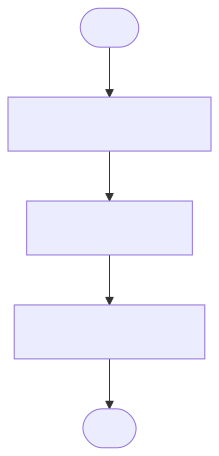

In [5]:

try:
    display(SVG(draw_kernel_process_mermaid(kernel_process)))
except Exception as e:
    print("⚠️ Unable to display the graph visualization. This won't affect the rest of the notebook.")
    print(f"Reason: {e}")

### Load Data From Azure Storage Account

In [6]:
df = get_datafame_from_storage('data/usage.parquet')

In [7]:


user_input = "Return Average Data Center Temperatures?"


# Starting the kernel process with the initial state
async with await start(
    process=kernel_process,
    kernel=kernel,
    initial_event=KernelProcessEvent(id="Start", data={'df':df,'input':user_input}),
) as process_context:
    _ = await process_context.get_state()

GenerateQueryStep
	 Generating Query for Return Average Data Center Temperatures?
RunQueryStep
	 Running Code result = df['temperature_c'].mean()
ExplainResultStep
	 Explain Results 24.6198
The average data center temperature provided is **24.62°C** (rounded to two decimal places).


In [8]:

user_input = "Return Average Data Center Temperatures?"


# Starting the kernel process with the initial state
async with await start(
    process=kernel_process,
    kernel=kernel,
    initial_event=KernelProcessEvent(id="Start", data={'df':df,'input':user_input}),
) as process_context:
    _ = await process_context.get_state()

GenerateQueryStep
	 Generating Query for Return Average Data Center Temperatures?
RunQueryStep
	 Running Code result = df.groupby('data_center_id')['temperature_c'].mean()
ExplainResultStep
	 Explain Results data_center_id
DC-CHI2    24.116739
DC-NYC1    25.283846
DC-OMA1    24.829643
Name: temperature_c, dtype: float64
To calculate the average temperature across all the data centers, you find the mean of the given temperatures:

- DC-CHI2: 24.116739°C
- DC-NYC1: 25.283846°C
- DC-OMA1: 24.829643°C

**Average temperature = (24.116739 + 25.283846 + 24.829643) / 3**

**Average temperature = 74.230228 / 3**

**Average temperature ≈ 24.7434°C**

The average temperature across the data centers is approximately **24.74°C**.
